# data_preprocessor

In [1]:
"""
    Turbofan data preprocessor to download, prepare and split the NASA turbofan data set in needed parts.
"""
import os
import pandas as pd
import random
import argparse
import requests
import zipfile
from tqdm import tqdm

## functions

In [2]:
def download_datasets():
    """ Download and unzip the NASA turbofan dataset. """
    file_name = "data.zip"
    url = "http://ti.arc.nasa.gov/c/6/"
    response = requests.get(url, stream=True)
    with open(file_name, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    my_zip = zipfile.ZipFile('data.zip')
    storage_path = './data/'
    for file in my_zip.namelist():
        if my_zip.getinfo(file).filename.endswith('.txt'):
            my_zip.extract(file, storage_path)

    os.remove(file_name)

In [3]:
def import_data(dataset_id):
    """ Import the turbofan training and test data and the test RUL values from the data files.

    :param dataset_id: The dataset from turbofan to import
    :return: A tuple with the training dataset, the test dataset and the test rul data
    """
    # define the columns in the dataset
    operational_settings = ['operational_setting_{}'.format(i + 1) for i in range(3)]
    sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(23)]
    cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns

    # # load the data
    # dirname = os.getcwd()
    # folder_path = os.path.join(dirname, 'data')

    train_path = 'https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_{}.txt'.format(dataset_id)
    # train_path = os.path.join(folder_path, 'train_{}.txt'.format(dataset_id))
    train_data = pd.read_csv(train_path, delim_whitespace=True, header=None, names=cols)
    train_data.set_index('time_in_cycles')
    test_path = 'https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_{}.txt'.format(dataset_id)
    # test_path = os.path.join(folder_path, 'test_{}.txt'.format(dataset_id))
    test_data = pd.read_csv(test_path, delim_whitespace=True, header=None, names=cols)
    test_data.set_index('time_in_cycles')
    test_data_rul_path = 'https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_{}.txt'.format(dataset_id)
    # test_data_rul_path = os.path.join(folder_path, 'RUL_{}.txt'.format(dataset_id))
    test_data_rul = pd.read_csv(test_data_rul_path, delim_whitespace=True, header=None, names=['RUL'])

    return train_data, test_data, test_data_rul


In [4]:
def save_data(train_data_initial, train_data_worker, test_data_val, test_data_test):
    """ Save the prepared data sets into csv files.

    :param train_data_initial: The data for initial training to save
    :param train_data_worker: An array of data for every worker to save
    :param test_data_val: The validation data to save
    :param test_data_test: The test data to save
    :return: None
    """
    dirname = os.getcwd()
    folder_path = os.path.join(dirname, 'data')

    train_data_initial_path = os.path.join(folder_path, 'train_data_initial.txt')
    train_data_initial.to_csv(train_data_initial_path, index=False)

    for index, data in enumerate(train_data_worker):
        train_data_worker_path = os.path.join(folder_path, 'train_data_worker_{}.txt'.format(index + 1))
        data.to_csv(train_data_worker_path, index=False)

    test_data_val_path = os.path.join(folder_path, 'test_data_val.txt')
    test_data_val.to_csv(test_data_val_path, index=False)

    test_data_test_path = os.path.join(folder_path, 'test_data_test.txt')
    test_data_test.to_csv(test_data_test_path, index=False)


In [5]:
def add_rul_to_test_data(test_data, test_data_rul):
    """ Enhance each row in the test data with the RUL. This is done inplace.

    :param test_data: The test data to enhance
    :param test_data_rul: The final RUL values for the engines in the test data
    :return: None
    """
    # prepare the RUL file data
    test_data_rul['engine_no'] = test_data_rul.index + 1
    test_data_rul.columns = ['final_rul', 'engine_no']

    # retrieve the max cycles in the test data
    test_rul_max = pd.DataFrame(test_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
    test_rul_max.columns = ['engine_no', 'max']

    test_data = test_data.merge(test_data_rul, on=['engine_no'], how='left')
    test_data = test_data.merge(test_rul_max, on=['engine_no'], how='left')

    # add the current RUL for every cycle
    test_data['RUL'] = test_data['max'] + test_data['final_rul'] - test_data['time_in_cycles']
    test_data.drop(['max', 'final_rul'], axis=1, inplace=True)

    return test_data


In [6]:
def split_train_data_by_engines(train_data, engine_percentage_initial, worker_count):
    """ Groups the train data by engines and split it into subsets for initial training and for each worker.

    :param train_data: The full training data set
    :param engine_percentage_initial: The percentage of engines to take for initial training
    :param worker_count: The number of workers to prepare data sets for
    :return: A tuple with the initial training data and an array of the worker data
    """
    train_data_per_engines = train_data.groupby('engine_no')
    train_data_per_engines = [train_data_per_engines.get_group(x) for x in train_data_per_engines.groups]
    random.shuffle(train_data_per_engines)

    # split into data for initial training and data for the worker nodes
    engine_count_initial = int(len(train_data_per_engines) * engine_percentage_initial / 100)
    train_data_initial = pd.concat(train_data_per_engines[:engine_count_initial])
    train_data_worker_all = train_data_per_engines[engine_count_initial:]

    train_data_worker = []
    engine_count_worker = int((len(train_data_per_engines) - engine_count_initial) / worker_count)

    # split worker data into the data sets for every single worker
    for i in range(worker_count):
        start = i * engine_count_worker
        end = start + engine_count_worker
        train_data_worker.append(pd.concat(train_data_worker_all[start:end]))

    return train_data_initial, train_data_worker


In [7]:
def split_test_data_by_engines(test_data, engine_percentage_val):
    """ Groups the train data by engines and split it into a subset for validation and one for testing.

    :param test_data: The full test data set
    :param engine_percentage_val: The percentage of engines to take for validation
    :return: A tuple of the validation and the test data
    """
    test_data_per_engines = test_data.groupby('engine_no')
    test_data_per_engines = [test_data_per_engines.get_group(x) for x in test_data_per_engines.groups]
    random.shuffle(test_data_per_engines)

    engine_count_val = int(len(test_data_per_engines) * engine_percentage_val / 100)
    test_data_val = pd.concat(test_data_per_engines[:engine_count_val])
    test_data_test = pd.concat(test_data_per_engines[engine_count_val:])

    return test_data_val, test_data_test

## MAIN

In [8]:
    dataset_id = "FD001"
    engine_percentage_initial = 5
    engine_percentage_val = 50
    worker_count = 5
    no_download = None

    if not no_download:
        print('Starting download of datasets')
        storage_path = './data/'
        try:
          os.mkdir(storage_path)
        except OSError:
          print("Fail mkdir")
        else:
          print("Success mkdir")
        # download_datasets()

    print("\n##########")
    print("Importing data for data set {}".format(dataset_id))
    train_data, test_data, test_data_rul = import_data(dataset_id)
    test_data = add_rul_to_test_data(test_data, test_data_rul)

    print("Splitting training data into subsets")
    print("Using {}% data for initial training".format(engine_percentage_initial))
    print("Creating subsets for {} worker".format(worker_count))
    train_data_initial, train_data_worker = split_train_data_by_engines(
        train_data,
        engine_percentage_initial,
        worker_count
    )
    print("Splitting test data into sets for validation and testing")
    print("Using {}% data for validation".format(engine_percentage_val))
    test_data_val, test_data_test = split_test_data_by_engines(test_data, engine_percentage_val)

    print("Saving data sets")
    save_data(train_data_initial, train_data_worker, test_data_val, test_data_test)
    print("Done")
    print("##########")

Starting download of datasets
Success mkdir

##########
Importing data for data set FD001
Splitting training data into subsets
Using 5% data for initial training
Creating subsets for 5 worker
Splitting test data into sets for validation and testing
Using 50% data for validation
Saving data sets
Done
##########


# Turbofan POC - Data Analysis

This notebook is a compact analysis of the initial dataset for the turbofan POC based on the NASA turbofan dataset.

## Imports

In [9]:
# # check if we are inside google colab
# try:
#     from google.colab import drive
#     # mount gdrive for importing the data
#     drive.mount('/content/gdrive', force_remount=True)
#     # change this path to your notebooks directory inside google drive
#     %cd /content/gdrive/My\ Drive/dev/turbofan_poc/notebooks

#     # set tensorflow version
#     %tensorflow_version 2.x
# except:
#     pass

In [10]:
import os
import numpy as np
import pandas as pd
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Data Import and Preparations

Let´s load the dataset with our initial training data.

In [11]:
# load the data 
dirname = os.getcwd()
data_path = os.path.join(dirname, './data')
train_data_path = os.path.join(data_path, 'train_data_initial.txt')
train_data = pd.read_csv(train_data_path)
train_data.set_index('time_in_cycles')

display(train_data.sample(3))
display(train_data.head(5))
display(train_data.tail(5))
display(train_data.shape)

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
756,53,31,-0.0011,-0.0002,100.0,518.67,642.24,1586.54,1401.94,14.62,21.60,553.37,2388.07,9057.65,1.3,47.38,521.68,2388.06,8136.94,8.4212,0.03,391,2388,100.0,38.96,23.3953,NaN,NaN
405,25,193,0.0029,-0.0001,100.0,518.67,643.40,1591.68,1418.37,14.62,21.61,552.80,2388.11,9090.71,1.3,47.74,520.48,2388.11,8167.66,8.4791,0.03,394,2388,100.0,38.57,23.1232,NaN,NaN
54,88,55,-0.0017,0.0000,100.0,518.67,642.11,1585.47,1405.29,14.62,21.61,553.68,2388.04,9063.92,1.3,47.46,521.50,2387.99,8147.96,8.4079,0.03,394,2388,100.0,39.12,23.3258,NaN,NaN


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
0,88,1,-0.0034,0.0003,100.0,518.67,642.31,1573.02,1404.47,14.62,21.60,554.38,2388.03,9059.25,1.3,47.33,521.84,2388.00,8146.05,8.4120,0.03,393,2388,100.0,39.12,23.3496,NaN,NaN
1,88,2,0.0010,-0.0004,100.0,518.67,642.37,1586.55,1398.07,14.62,21.61,554.06,2388.02,9066.88,1.3,47.18,522.02,2387.97,8147.36,8.4244,0.03,393,2388,100.0,39.12,23.4727,NaN,NaN
2,88,3,-0.0029,0.0001,100.0,518.67,642.38,1587.81,1404.04,14.62,21.61,554.08,2388.02,9065.97,1.3,47.39,521.87,2388.05,8149.18,8.4138,0.03,392,2388,100.0,38.89,23.3376,NaN,NaN
3,88,4,-0.0001,-0.0001,100.0,518.67,642.21,1582.43,1407.34,14.62,21.61,554.67,2388.03,9068.35,1.3,47.45,522.45,2388.04,8150.20,8.3916,0.03,392,2388,100.0,38.87,23.3907,NaN,NaN
4,88,5,0.0024,0.0002,100.0,518.67,641.62,1589.79,1400.40,14.62,21.61,553.97,2388.01,9071.88,1.3,47.30,522.31,2388.03,8140.86,8.4083,0.03,394,2388,100.0,38.96,23.2585,NaN,NaN


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
1104,40,184,0.0020,-0.0002,100.0,518.67,643.59,1604.29,1425.46,14.62,21.61,551.38,2388.18,9129.43,1.3,48.08,520.31,2388.19,8199.71,8.5105,0.03,396,2388,100.0,38.54,23.0755,NaN,NaN
1105,40,185,0.0007,-0.0002,100.0,518.67,643.32,1604.87,1427.30,14.62,21.61,552.45,2388.21,9127.07,1.3,48.12,519.56,2388.18,8194.02,8.5312,0.03,397,2388,100.0,38.47,22.9686,NaN,NaN
1106,40,186,0.0002,0.0003,100.0,518.67,643.60,1614.93,1427.59,14.62,21.61,551.58,2388.22,9133.34,1.3,48.16,519.73,2388.21,8198.36,8.4929,0.03,396,2388,100.0,38.30,23.1198,NaN,NaN
1107,40,187,-0.0016,0.0000,100.0,518.67,644.06,1604.34,1428.42,14.62,21.61,550.87,2388.14,9133.51,1.3,48.15,519.75,2388.22,8198.90,8.4856,0.03,397,2388,100.0,38.50,23.0906,NaN,NaN
1108,40,188,0.0002,-0.0003,100.0,518.67,643.87,1611.92,1432.96,14.62,21.61,551.08,2388.23,9142.42,1.3,48.03,520.33,2388.25,8202.76,8.5350,0.03,397,2388,100.0,38.37,23.1022,NaN,NaN


(1109, 28)

There is an engine number defining the original engine data series, there is the current cycle and then there are 3 operational settings and 23 sensors.

Now we need to add the labels to the data calculating the max cycle per engine and then adding the current RUL per engine.

In [12]:
# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
# merge the RULs into the training data
train_rul.columns = ['engine_no', 'max']
train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
# add the current RUL for every cycle
train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
train_data.drop('max', axis=1, inplace=True)
train_data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,RUL
0,88,1,-0.0034,0.0003,100.0,518.67,642.31,1573.02,1404.47,14.62,21.60,554.38,2388.03,9059.25,1.3,47.33,521.84,2388.00,8146.05,8.4120,0.03,393,2388,100.0,39.12,23.3496,NaN,NaN,212
1,88,2,0.0010,-0.0004,100.0,518.67,642.37,1586.55,1398.07,14.62,21.61,554.06,2388.02,9066.88,1.3,47.18,522.02,2387.97,8147.36,8.4244,0.03,393,2388,100.0,39.12,23.4727,NaN,NaN,211
2,88,3,-0.0029,0.0001,100.0,518.67,642.38,1587.81,1404.04,14.62,21.61,554.08,2388.02,9065.97,1.3,47.39,521.87,2388.05,8149.18,8.4138,0.03,392,2388,100.0,38.89,23.3376,NaN,NaN,210
3,88,4,-0.0001,-0.0001,100.0,518.67,642.21,1582.43,1407.34,14.62,21.61,554.67,2388.03,9068.35,1.3,47.45,522.45,2388.04,8150.20,8.3916,0.03,392,2388,100.0,38.87,23.3907,NaN,NaN,209
4,88,5,0.0024,0.0002,100.0,518.67,641.62,1589.79,1400.40,14.62,21.61,553.97,2388.01,9071.88,1.3,47.30,522.31,2388.03,8140.86,8.4083,0.03,394,2388,100.0,38.96,23.2585,NaN,NaN,208


## Data Analysis

### Basic Information

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109 entries, 0 to 1108
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   engine_no              1109 non-null   int64  
 1   time_in_cycles         1109 non-null   int64  
 2   operational_setting_1  1109 non-null   float64
 3   operational_setting_2  1109 non-null   float64
 4   operational_setting_3  1109 non-null   float64
 5   sensor_measurement_1   1109 non-null   float64
 6   sensor_measurement_2   1109 non-null   float64
 7   sensor_measurement_3   1109 non-null   float64
 8   sensor_measurement_4   1109 non-null   float64
 9   sensor_measurement_5   1109 non-null   float64
 10  sensor_measurement_6   1109 non-null   float64
 11  sensor_measurement_7   1109 non-null   float64
 12  sensor_measurement_8   1109 non-null   float64
 13  sensor_measurement_9   1109 non-null   float64
 14  sensor_measurement_10  1109 non-null   float64
 15  sens

In [14]:
# check how many original turbofan engine series we have
len(train_data['engine_no'].unique())

5

There are 5 complete time series of turbofan engine data.

We remove the empty sensors.

In [15]:
cols_nan = train_data.columns[train_data.isna().any()].tolist()
print('Columns without data: \n' + str(cols_nan) + '\n')

train_data = train_data.drop(columns=cols_nan)

Columns without data: 
['sensor_measurement_22', 'sensor_measurement_23']



In [16]:
# define column sets for the analysis
info_cols = ['engine_no', 'time_in_cycles', 'RUL']
operational_cols = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_cols = ['sensor_measurement_{}'.format(i + 1) for i in range(21)]

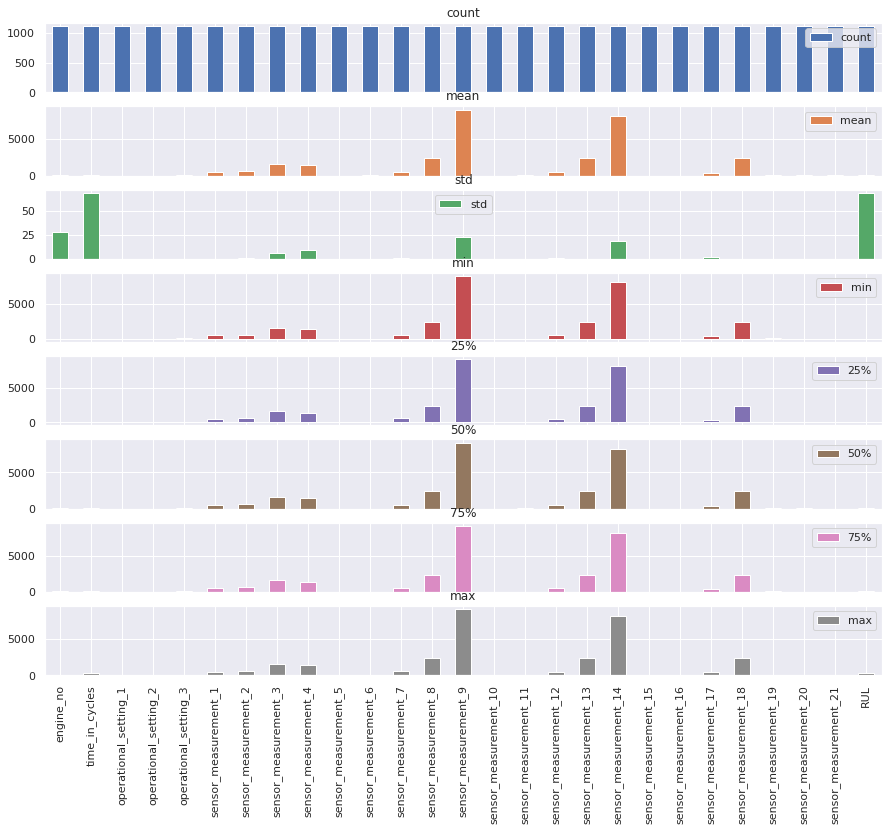

In [17]:
# plot an overview of whats going on in the columns
axes = train_data.describe().T.plot.bar(subplots=True, figsize=(15,12))

There are some sensors with constant constant values:

In [18]:
cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')

Columns with constant values: 
['operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']



### Correlations

Check the correlations:

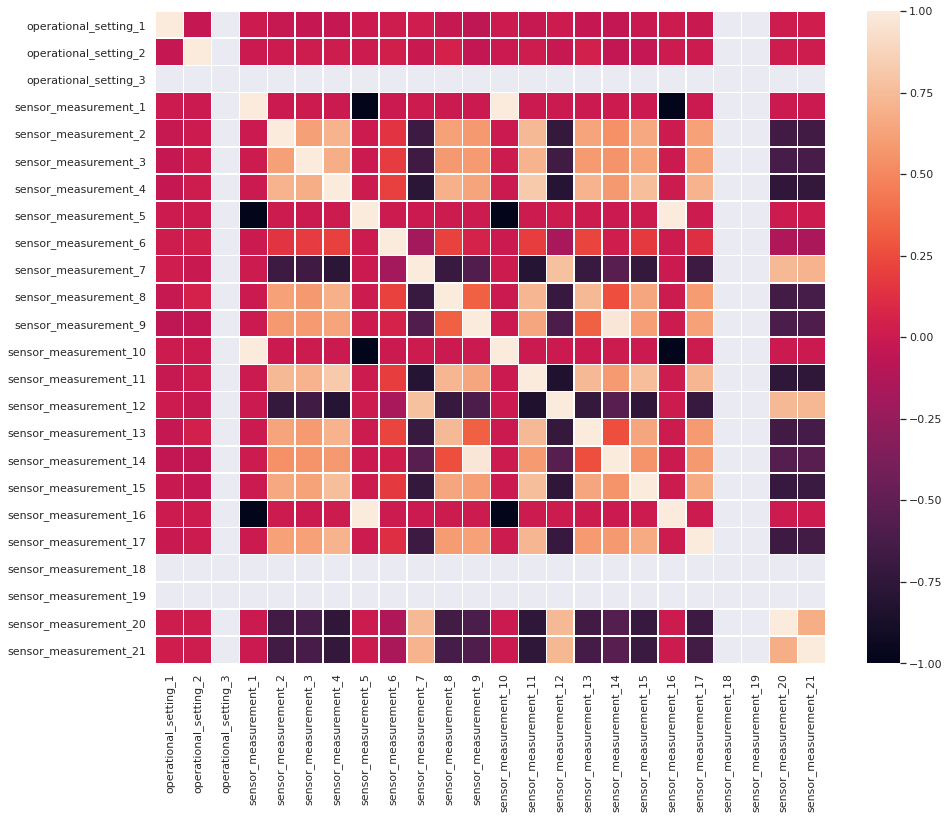

In [19]:
# print correlation heatmap
analysis_data_corr = train_data[operational_cols + sensor_cols].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(analysis_data_corr, linewidths=.5)

In [20]:
# print highly correlated values
analysis_data_corr2 = pd.DataFrame(np.tril(analysis_data_corr.values), columns=analysis_data_corr.columns, index = analysis_data_corr.index)

correlating = []
for col in analysis_data_corr2.columns:
    ser = analysis_data_corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c))

print('Highly correlating values:')
for c in correlating:
    print(c)

Highly correlating values:
('sensor_measurement_1', 'sensor_measurement_5', -1.0)
('sensor_measurement_1', 'sensor_measurement_10', 1.0)
('sensor_measurement_1', 'sensor_measurement_16', -1.0)
('sensor_measurement_4', 'sensor_measurement_11', 0.8272447110638781)
('sensor_measurement_5', 'sensor_measurement_10', -1.0)
('sensor_measurement_5', 'sensor_measurement_16', 1.0)
('sensor_measurement_7', 'sensor_measurement_11', -0.8023145979428765)
('sensor_measurement_9', 'sensor_measurement_14', 0.9691891959195891)
('sensor_measurement_10', 'sensor_measurement_16', -1.0)
('sensor_measurement_11', 'sensor_measurement_12', -0.8285306100420841)


Sensor 1, 5, 10 and 16 have constant values so we can ignore these correlations.

### Time and Distribution Plots

#### We will start with plotting the sensor data for all engines in a row. 

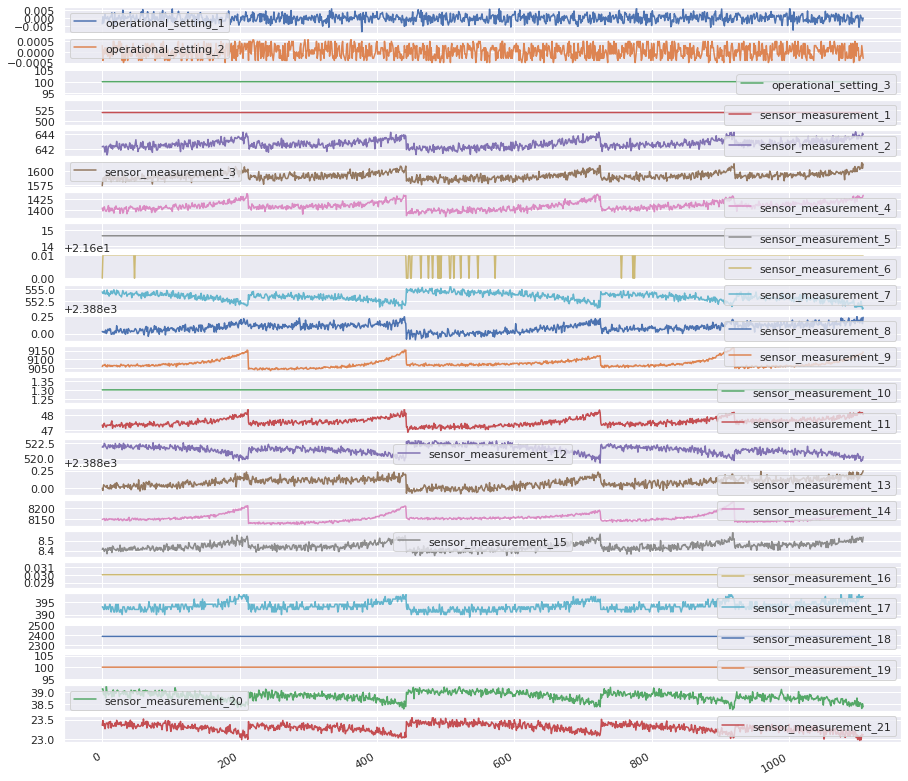

In [21]:
# plot all train data by sensors
t = train_data[operational_cols + sensor_cols].plot(subplots=True, figsize=(15, 15))

#### Now we plot the train data but grouped by our engines.

In [22]:
# inverse the RUL for the plot
train_data['RUL'] = train_data['RUL'] * -1

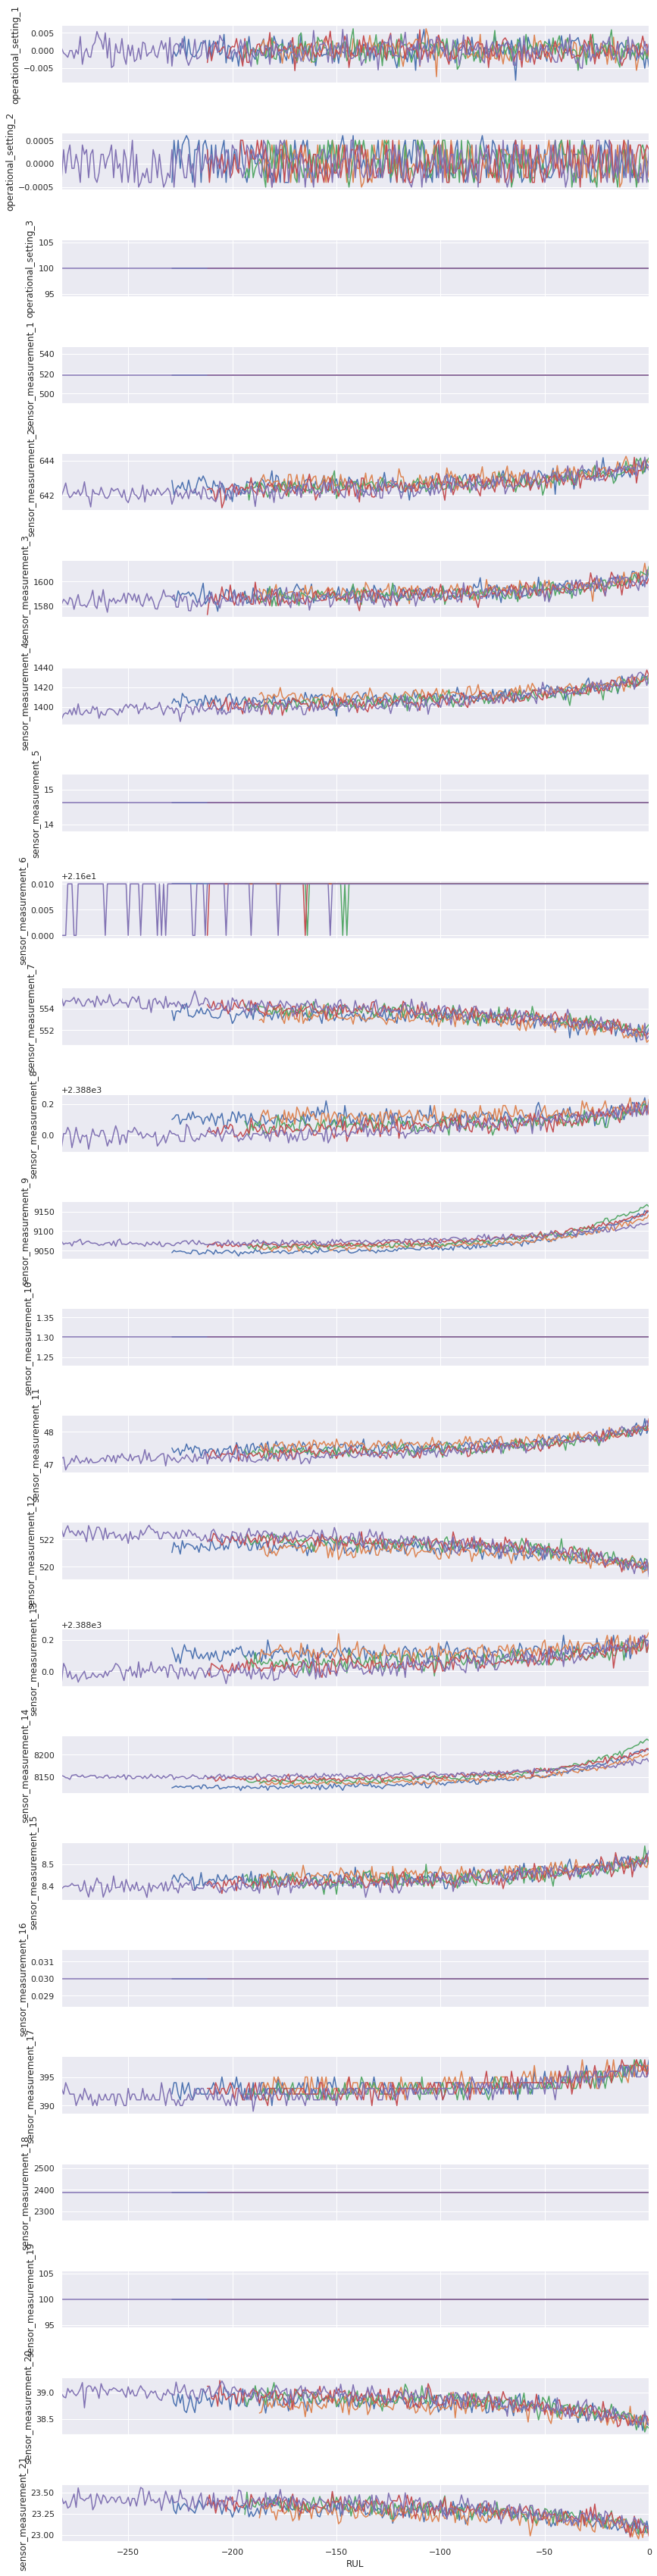

In [23]:
# plot all engines sensor data
g = sns.PairGrid(data=train_data, x_vars='RUL', y_vars=operational_cols+sensor_cols, hue="engine_no", height=2, aspect=6,)
g = g.map(plt.plot)
g = g.set(xlim=(train_data['RUL'].min(), train_data['RUL'].max()))

#### Let´s plot a single engine and try several engines.

In [24]:
engine_series_length = train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max().sort_values()
shortest_engine = engine_series_length.index[0]
longest_engine = engine_series_length.index[-1]

print("The engine with the shortest cycles is nr. {} with {} cycles lifetime and the one with the longest cycles run is nr. {} running {} cycles.".\
      format(shortest_engine, engine_series_length.iloc[0], longest_engine, engine_series_length.iloc[-1]))

The engine with the shortest cycles is nr. 40 with 188 cycles lifetime and the one with the longest cycles run is nr. 95 running 283 cycles.


In [25]:
# plot a single engines sensor data
def plot_engine_data(engine_no, engine_data):
  window_size = 20
  cols = engine_data.columns
  fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))

  for col, ax in zip(cols, axes):
      engine_data[col].plot(ax = ax)
      engine_data[col].rolling(window_size).median().plot(ax = ax)
      engine_data[col].rolling(window_size).mean().plot(style = '--', legend=True, ax = ax)
  fig.suptitle('Engine Nr: {}'.format(engine_no))

In [26]:
# plot a single engines hists
def plot_engine_hists(engine_data):
  cols = engine_data.columns
  n_cols = min(len(cols), 4)
  n_rows = int(np.ceil(len(cols) / n_cols))

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))
  plt.tight_layout()
  axes = axes.flatten()
  for col, ax in zip(cols, axes):
      sns.distplot(engine_data[[col]], ax=ax, label=col)
      ax.set_xlabel(col)
      ax.set_ylabel("p")

In [27]:
def plot_engine(engine_no):
  window_size = 20
  engine_data = train_data[train_data.engine_no == engine_no]
  engine_data = engine_data.drop(columns=['engine_no', 'RUL'])
  # drop constant values
  engine_data = engine_data.drop(columns=cols_const)

  plot_engine_data(engine_no, engine_data)
  plot_engine_hists(engine_data)

##### engine with the shortest cycles

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

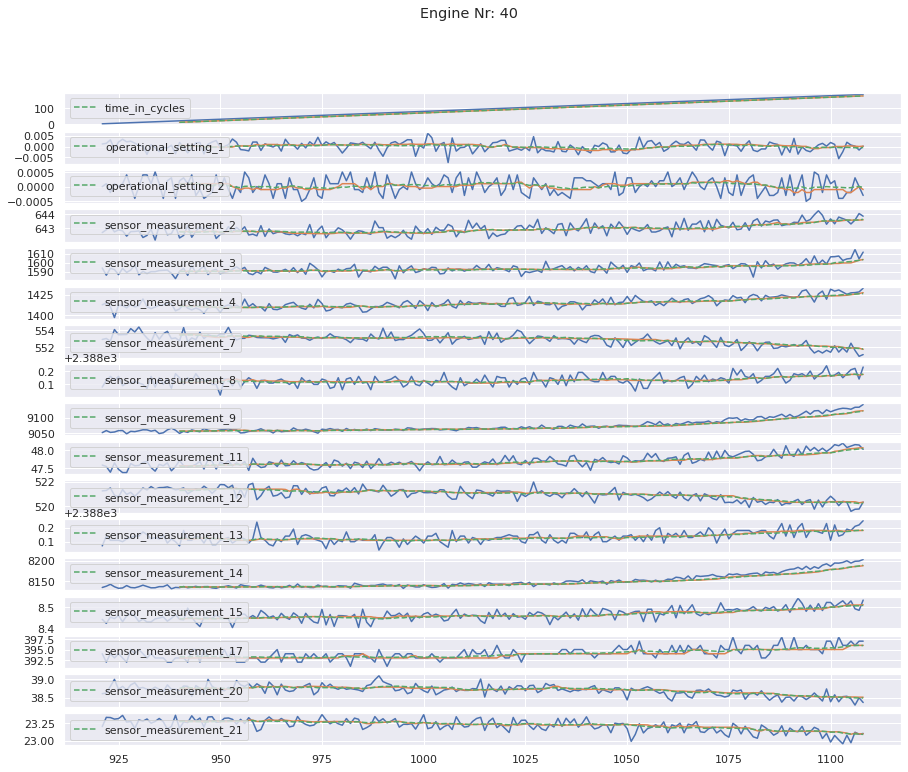

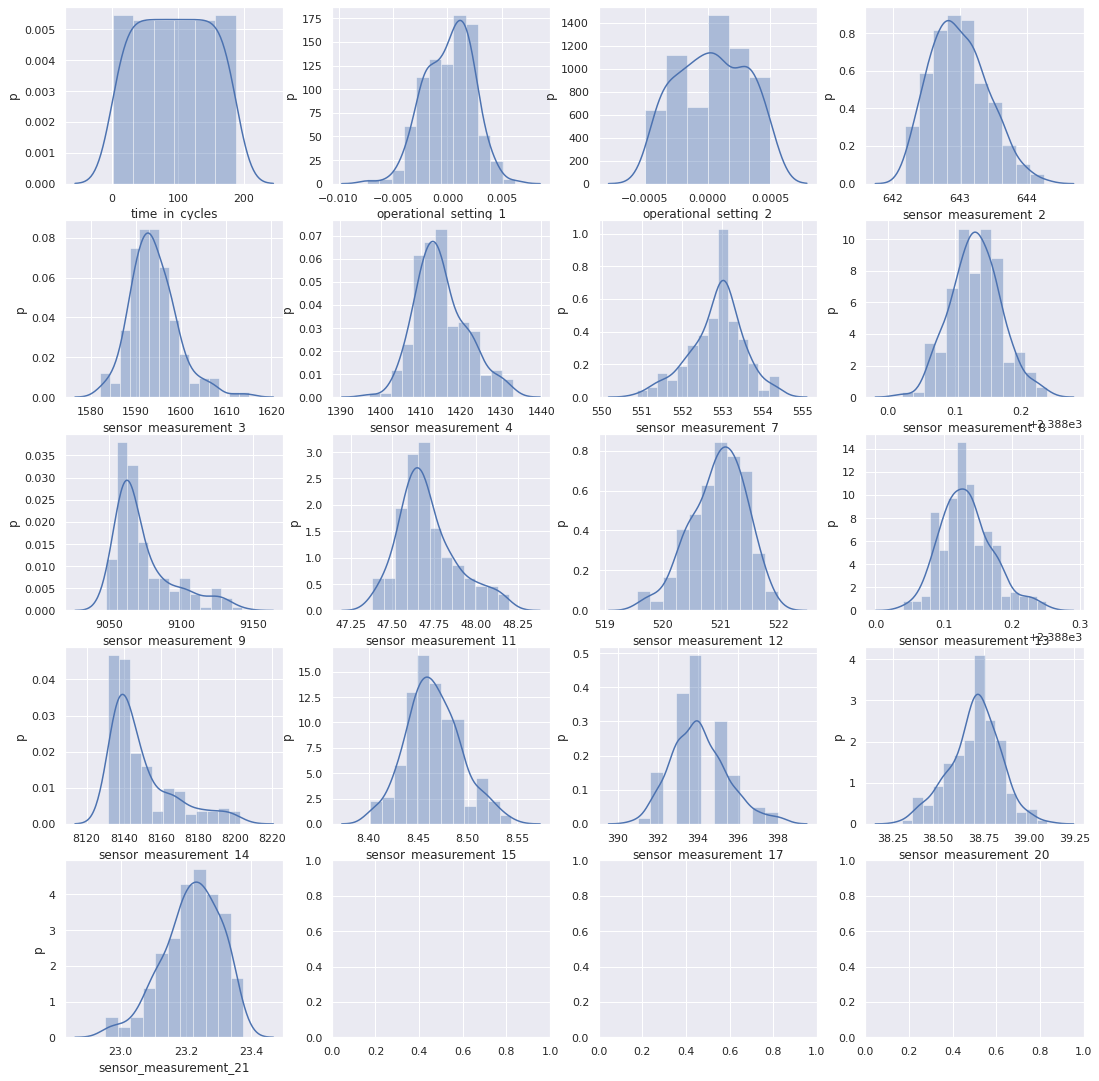

In [28]:
# plot engine with the shortest cycles
plot_engine(shortest_engine)

##### engine with the longest cycles

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

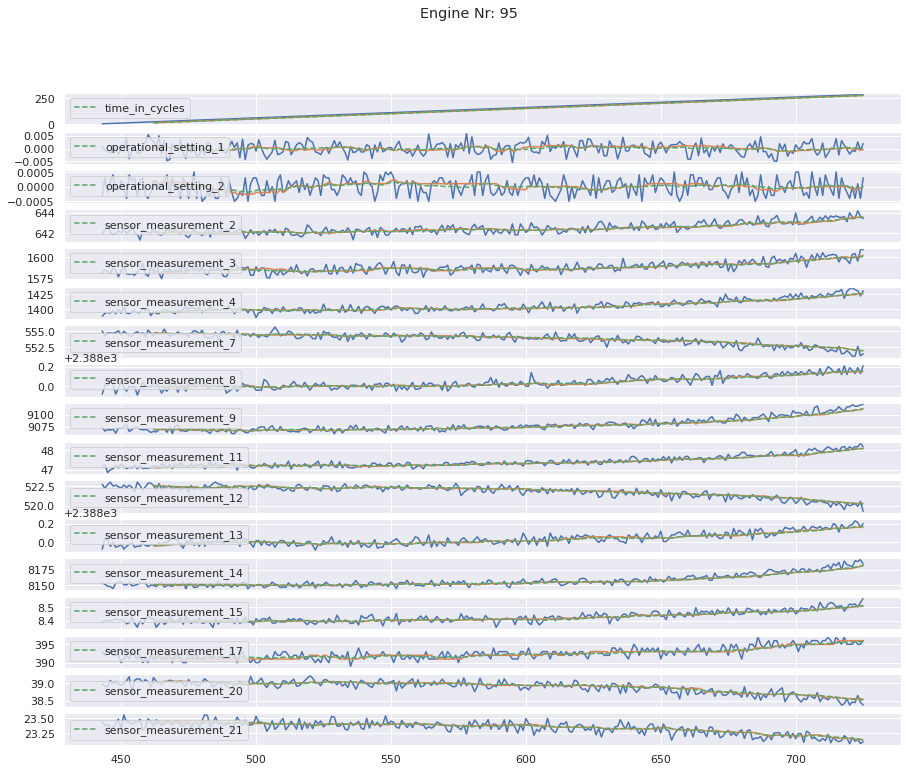

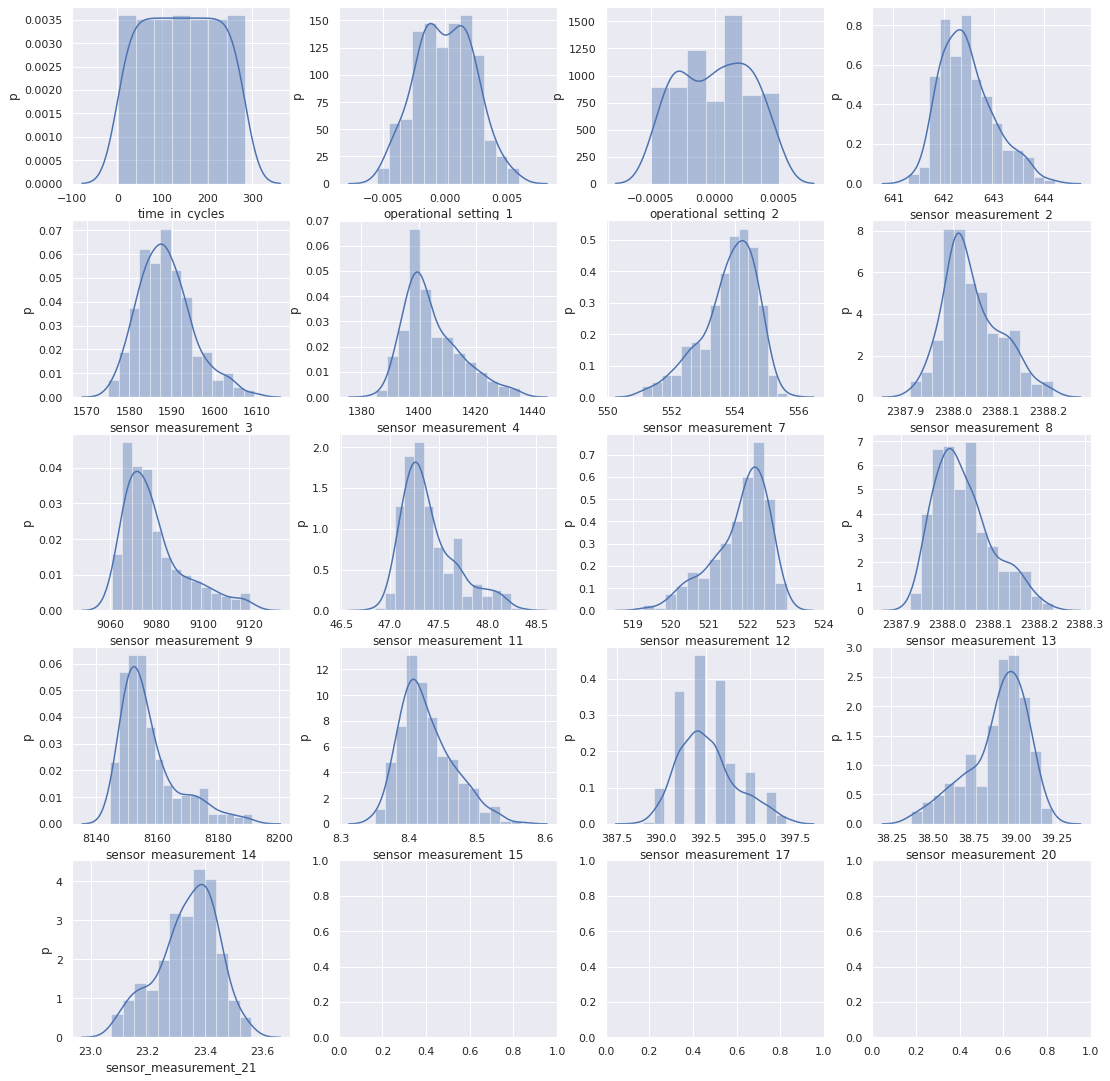

In [29]:
# plot engine with the longest cycles
plot_engine(longest_engine)

##### Let´s have a look at the number of cycles the engines run before a failure.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


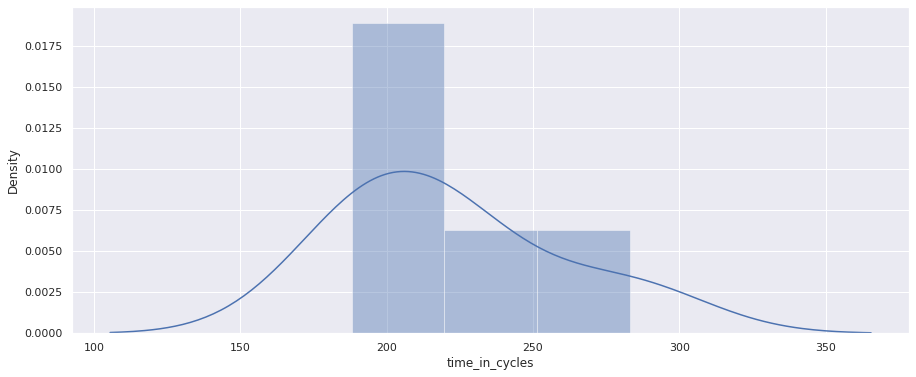

In [30]:
cycles_per_engine = train_data.groupby(['engine_no'], sort=False)['time_in_cycles'].max()
fig = plt.figure(figsize=(15, 6))
ax2 = sns.distplot(pd.Series(cycles_per_engine) ,label='operation times')

# Turbofan POC - Initial Training and Model Serving

This notebook is creating an initial model for predictions of the RUL for our turbofan engines.

## Imports and Data Preprocessing

In [31]:
# # check if we are inside google colab
# try:
#     from google.colab import drive
#     # mount gdrive for importing the data
#     drive.mount('/content/gdrive', force_remount=True)
#     # change this path to your notebooks directory inside google drive
#     %cd /content/gdrive/My\ Drive/dev/turbofan_poc/notebooks

#     # set tensorflow version
#     %tensorflow_version 2.x
# except:
#     pass

In [32]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [33]:
# load the data 
dirname = os.getcwd()
folder_path = os.path.join(dirname, './data')

train_data_path = os.path.join(folder_path, 'train_data_initial.txt')
train_data = pd.read_csv(train_data_path)
train_data.set_index('time_in_cycles')

val_data_path = os.path.join(folder_path, 'test_data_val.txt')
val_data = pd.read_csv(val_data_path)
val_data.set_index('time_in_cycles')

test_data_path = os.path.join(folder_path, 'test_data_test.txt')
test_data = pd.read_csv(test_data_path)
test_data.set_index('time_in_cycles')

# retrieve the max cycles per engine: RUL
train_rul = pd.DataFrame(train_data.groupby('engine_no')['time_in_cycles'].max()).reset_index()
# merge the RULs into the training data
train_rul.columns = ['engine_no', 'max']
train_data = train_data.merge(train_rul, on=['engine_no'], how='left')
# add the current RUL for every cycle
train_data['RUL'] = train_data['max'] - train_data['time_in_cycles']
train_data.drop('max', axis=1, inplace=True)

# test and validation data already contains the RUL values

# drop the columns not needed
cols_nan = train_data.columns[train_data.isna().any()].tolist()
cols_const = [ col for col in train_data.columns if len(train_data[col].unique()) <= 2 ]

# The operational settings 1 and 2 don´t have a trend and they look like random noise.
# Sensors 11, 12, 13 could be removed due to high correlations but it should be tested.
# The trend of sensors 9 and 14 depend on the specific engine. Some engines at the end
# of life tend to increase while others tend to decrease. What is common about these
# two sensors is that the magnitude at the end life gets amplified. We should try
# removing both sensors.
cols_irrelevant = ['operational_setting_1', 'operational_setting_2', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13']

# Drop the columns without or with constant data
train_data = train_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
val_data = val_data.drop(columns=cols_const + cols_nan + cols_irrelevant)
test_data = test_data.drop(columns=cols_const + cols_nan + cols_irrelevant)

## Data Preparation

In [34]:
# define the columns for training
train_data_inputs = train_data.copy()
train_data_inputs.drop(columns=['RUL', 'engine_no', 'time_in_cycles'], inplace=True)
training_columns = train_data_inputs.columns

### Windowing

To do our model training we split the data from an engine into rolling windows so we have the dimensions (total number of rows, time steps per window, feature columns).

*Engine x for window size 3:*

```
[1 2 3 4 5 6] -> [1 2 3], [2 3 4], [3 4 5], [4 5 6]
```

As labels we pick the RUL of the last value in the windowed sequence.

By splitting the data into windows we have to drop data samples that are smaller than the window size. This especially means we can not predict RUL values for smaller time series of engine data. An alternative would be to pad sequences so that we can use shorter ones.

In [35]:
WINDOW_SIZE = 80
BATCH_SIZE = 210

In [36]:
def transform_to_windowed_data(dataset, window_size, window_limit = 0, verbose = True):
  """Transform the dataset into input windows with a label.

  Args:
      dataset (DataFrame): The dataset to tranform.
      window_size (int): The length of the windows to create.
      window_limit (int): The max windows to create for a data subset.

  Returns:
      (numpy.array, numpy.array): A tuple of features and labels.
  """
  features = []
  labels = []

  dataset = dataset.set_index('time_in_cycles')
  data_per_engine = dataset.groupby('engine_no')

  for engine_no, engine_data in data_per_engine:
      # skip if the engines cycles are too few
      if len(engine_data) < window_size + window_limit -1:
        continue

      if window_limit != 0:
        window_count = window_limit
      else:
        window_count = len(engine_data) - window_size

      for i in range(0, window_count):
        # take the last x cycles where x is the window size
        start = -window_size - i
        end = len(engine_data) - i
        inputs = engine_data.iloc[start:end]
        # use the RUL of the last cycle as label
        outputs = engine_data.iloc[end - 1, -1]

        inputs = inputs.drop(['engine_no', 'RUL'], axis=1)

        features.append(inputs.values)
        labels.append(outputs)

  features = np.array(features)
  labels = np.array(labels)
  labels = np.expand_dims(labels, axis=1)

  if verbose:
    print("{} features with shape {}".format(len(features), features[0].shape))
    print("{} labels with shape {}".format(len(labels), labels.shape))

  return features, labels

In [37]:
x_train, y_train = transform_to_windowed_data(train_data, WINDOW_SIZE)
x_val, y_val = transform_to_windowed_data(val_data, WINDOW_SIZE)
x_test, y_test = transform_to_windowed_data(test_data, WINDOW_SIZE)

709 features with shape (80, 11)
709 labels with shape (709, 1)
2899 features with shape (80, 11)
2899 labels with shape (2899, 1)
2684 features with shape (80, 11)
2684 labels with shape (2684, 1)


### Standardization

The data scaling will be embedded in the model so it could be easily applied to inference as well.

### Response Clipping

Since the degradation in a system will generally remain negligible until after some period of operation time the early and higher RUL values are probably unreasonable. We could tackle this by clipping the RUL values.

That means we are fine with our model not correctly predicting RUL values above the *rul_clip_limit*. The model will still correctly identify that these engines but it is kind of cheating as the error for these engines improves.

In [38]:
# clip RUL values
rul_clip_limit = 110

y_train = y_train.clip(max=rul_clip_limit)
y_val = y_val.clip(max=rul_clip_limit)
y_test = y_test.clip(max=rul_clip_limit)

## Model Training

### Helpers

In [39]:
# RMSE implementation
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

### Model Definition

Vanilla LSTM (RNN)

In [40]:
class TurbofanModel(nn.Module):
    def __init__(self, train_mean, train_std):
        super().__init__()
        
        self.train_mean = train_mean
        self.train_std = train_std

        self.fc1 = nn.Linear(len(training_columns), 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 1)

    def to(self, device):
        super().to(device)
        self.train_mean = self.train_mean.to(device)
        self.train_std = self.train_std.to(device)
        
        return self
        
    def forward(self, x):
        # scale the input
        x = (x - self.train_mean) / self.train_std

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x[:, -1, :]
        
        return x

### Prepare Data Loader

In [41]:
# transform to torch tensor
tensor_x_train = torch.Tensor(x_train)
tensor_y_train = torch.Tensor(y_train)
tensor_x_val = torch.Tensor(x_val)
tensor_y_val = torch.Tensor(y_val)
tensor_x_test = torch.Tensor(x_test)
tensor_y_test = torch.Tensor(y_test)

# create datasets for train, test and validation
train_dataset = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val)
test_dataset = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Initial Training

Finally play ...

In [42]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()

    running_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss

In [43]:
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item() * data.size(0)

    test_loss /= len(test_loader.dataset)

    return test_loss

In [44]:
torch.manual_seed(1)
np.random.seed(51)

epochs = 280

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

mean = tensor_x_train.mean(0)
std = tensor_x_train.std(0)
model = TurbofanModel(mean, std).to(device)

criterion = nn.L1Loss() # mae
optimizer = optim.Adam(model.parameters())

history = {}
history['epoch'] = []
history['loss'] = []
history['val_loss'] = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = test(model, device, val_loader, criterion)

    print('Epoch: {}/{}\tloss: {:.4f}\tval_loss: {:.4f}'.format(epoch, epochs, train_loss, val_loss))

    history['epoch'].append(epoch)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)

Epoch: 1/280	loss: 67.0923	val_loss: 83.9257
Epoch: 2/280	loss: 67.0707	val_loss: 83.9008
Epoch: 3/280	loss: 67.0494	val_loss: 83.8748
Epoch: 4/280	loss: 67.0272	val_loss: 83.8463
Epoch: 5/280	loss: 67.0028	val_loss: 83.8142
Epoch: 6/280	loss: 66.9745	val_loss: 83.7768
Epoch: 7/280	loss: 66.9404	val_loss: 83.7319
Epoch: 8/280	loss: 66.8980	val_loss: 83.6757
Epoch: 9/280	loss: 66.8437	val_loss: 83.6020
Epoch: 10/280	loss: 66.7724	val_loss: 83.5036
Epoch: 11/280	loss: 66.6795	val_loss: 83.3767
Epoch: 12/280	loss: 66.5612	val_loss: 83.2176
Epoch: 13/280	loss: 66.4133	val_loss: 83.0201
Epoch: 14/280	loss: 66.2325	val_loss: 82.7759
Epoch: 15/280	loss: 66.0093	val_loss: 82.4738
Epoch: 16/280	loss: 65.7351	val_loss: 82.0988
Epoch: 17/280	loss: 65.3981	val_loss: 81.6346
Epoch: 18/280	loss: 64.9935	val_loss: 81.0599
Epoch: 19/280	loss: 64.5067	val_loss: 80.3551
Epoch: 20/280	loss: 63.9409	val_loss: 79.5022
Epoch: 21/280	loss: 63.2814	val_loss: 78.4798
Epoch: 22/280	loss: 62.5215	val_loss: 77.26

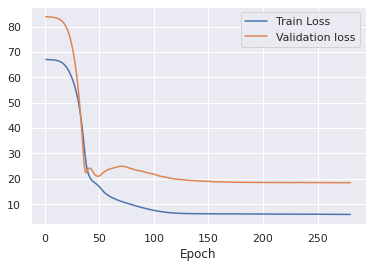

In [45]:
plt.figure()
plt.xlabel('Epoch')
plt.plot(history['epoch'], np.array(history['loss']), label='Train Loss')
plt.plot(history['epoch'], np.array(history['val_loss']), label = 'Validation loss')
plt.legend()

## Model Evaluation

Testing set RMSE:    25.54
Validation set RMSE:   24.71
Training set RMSE:    8.06


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

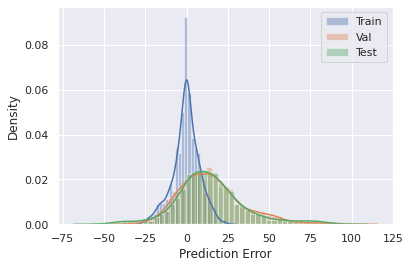

In [46]:
def plot_res(model, test_data, test_labels, val_data, val_labels, train_data, train_labels):
    output_test = model(test_data).to('cpu')
    rmse_test = root_mean_squared_error(test_labels, output_test)
    output_val = model(val_data).to('cpu')
    rmse_val = root_mean_squared_error(val_labels, output_val)
    output_train = model(train_data).to('cpu')
    rmse_train = root_mean_squared_error(train_labels, output_train)
    print("Testing set RMSE:  {:7.2f}".format(rmse_test))
    print("Validation set RMSE: {:7.2f}".format(rmse_val))
    print("Training set RMSE: {:7.2f}".format(rmse_train))

    test_predictions = output_test.flatten()
    val_predictions = output_val.flatten()
    train_predictions = output_train.flatten()
    sns.distplot(train_predictions - train_labels.flatten(), label = "Train")
    sns.distplot(val_predictions - val_labels.flatten(), label = "Val")
    sns.distplot(test_predictions - test_labels.flatten(), label = "Test")
    plt.xlabel("Prediction Error")
    _ = plt.legend()

model.eval()

tensor_x_train, tensor_x_val, tensor_x_test = tensor_x_train.to(device), tensor_x_val.to(device), tensor_x_test.to(device)

with torch.no_grad():
    plot_res(model, tensor_x_test, tensor_y_test, tensor_x_val, tensor_y_val, tensor_x_train, tensor_y_train)

## Save Model

In [47]:
# save the model to use it for the federated trainer
torch.save(model.to('cpu'), "./turbofan_initial.pt")